In [1]:
# Basic Imports
import numpy as np
import h5py as h5
#from sklearn.externals import joblib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.cross_validation import KFold
import pickle
import re
import random
import collections
import ipyparallel as ipp
from functools import partial
import collections
import tables as tb
from math import isnan

%matplotlib inline
#plt.rcParams['figure.figsize'] = (15, 10)
plt.style.use('ggplot')

/projects/nikhil/ADNI_prediction/code/conda_envs/adni-conda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
/projects/nikhil/ADNI_prediction/code/conda_envs/adni-conda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [43]:
#datasets
cohort = 'ADNI2'
exp_name = 'Exp6'
atlas = 'SpecCluster'

baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/'
HC_L_data_path = baseline_dir + 'HC/subject_HC_vol_dictionary_{}_left_{}.pkl'.format(cohort,exp_name)
HC_R_data_path = baseline_dir + 'HC/subject_HC_vol_dictionary_{}_right_{}.pkl'.format(cohort,exp_name)
CT_data_path = baseline_dir + 'CT/civet_out/{}_subject_ROI_CT_dict_{}.pkl'.format(cohort,atlas)
ADAS_data_path = baseline_dir + 'CS/{}_BL_PTID_ADAS13_dict.pkl'.format(cohort)
MMSE_data_path = baseline_dir + 'CS/{}_BL_PTID_MMSE_dict.pkl'.format(cohort)
CT_unique_ROIs_path = baseline_dir + 'CT/civet_out/ADNI_unique_ROIs_{}.pkl'.format(atlas)
DX_data_path = baseline_dir + 'CS/{}_BL_PTID_DX_bl_dict.pkl'.format(cohort)
#k-fold indices (from a saved file)
#kf_file = "/projects/nikhil/ADNI_prediction/input_datasets/cli_ct_train_valid_KFold_idx.pkl"
#kf_file = "/projects/nikhil/ADNI_prediction/input_datasets/cli_ct_train_valid_KFold_UIDs.pkl"



In [44]:
#Grab CV data with specific feature columes (independent vars) and specific clinical scale (dependent var)
def load_CV_data(sub_list, sub_HC_L_dict, sub_HC_R_dict, sub_CT_dict, sub_ADAS_dict, sub_MMSE_dict, sub_DX_dict, kf, hdf_file, cohort, min_CT_sampx):
    # Decide which input modalities / output variables you want to load and inflate
    # Use sub list to verify dictionary entry exists for each in the sub_HC / sub_CT /sub_CS dictionaries
    # Grab clinical score for each subject from master_csv table (infile) / or grab it from the sub_CS_dict
    # Filter out NANs 
    # Loop through K-folds (kf_file) and append candidate labels + CT values
    # Note: UID = PTID + IID (036_S_0976_I65091)
    # cohort = Train, Valid, or Heldout 
    # Pick any UID to generate roi_list common across all subjects to stay consistents while tranforming dictionary into array
    #ordered_roi_list = sub_CT_dict['137_S_0459'][0].keys()
    ordered_roi_list = pickle.load( open(CT_unique_ROIs_path, "rb" ) )
    
    # ignore the "0" idx along with the 4 missing rois from the mean CT value csv
    #ignore_roi_list = [0,29,30,39,40]
    
    if len(ordered_roi_list) < 100: #AAL
        ignore_roi_list = [0] #-1 (and -1+1000) index for the ROIs in the middle
    else: #SpecCluster
        ignore_roi_list = [-1,999] #-1 (and -1+1000) index for the ROIs in the middle
        
    for roi in ignore_roi_list:
        ordered_roi_list.remove(roi)
            

    # K-fold list
    #kf = pickle.load( open(kf_file, "rb" ) )
    train_fold_list = []
    val_fold_list = []
    for train, test in kf:
        tmp_train_list = []
        for t in train:
            tmp_train_list.append(sub_list[t])
        train_fold_list.append(tmp_train_list)
        
        tmp_val_list = []
        for t in test:
            tmp_val_list.append(sub_list[t])
        val_fold_list.append(tmp_val_list)
            
    if cohort == 'train':        
        #train_fold_list= kf['train_UIDs']       
        computeTrainingFolds = True
        drawSamples = True  #Draw samples or point estimates?
        
    elif cohort == 'valid':                
        #val_fold_list= kf['valid_UIDs']  
        computeTrainingFolds = False
        computeValidFolds = True
        drawSamples = False
        
    else:        
        print 'unknown cohort'    
    
    runParallel = False
    if runParallel: #parallelized version -- doesnt work :-(   
        rc = ipp.Client()
        #rc.block = False
        dview = rc[:]
        print dview
        dview.push(dict(inflate_fold = inflate_fold))        
        dview.push(dict(inflate_subject_samples = inflate_subject_samples))        
        mapfunc = partial(inflate_fold, sub_HC_L_dict=sub_HC_L_dict, sub_HC_R_dict=sub_HC_R_dict, sub_CT_dict=sub_CT_dict, 
                  ordered_roi_list=ordered_roi_list, sub_clinical_scores_dict=sub_clinical_scores_dict)

        parallel_result = dview.map_sync(mapfunc, train_fold_list)  
        return parallel_result
    
    else:
        fold = 0 
        uid_sampx_dict_list = []
        
        if computeTrainingFolds:             
            for train in train_fold_list:  
                #train = train_fold_list[-1]
                #fold = 10
                fold+=1                
                print 'Starting train subset'
                print 'Staring fold # {}'.format(fold)
                uid_sampx_dict = collections.OrderedDict() #keep track of number of samples generated per subject
                X_train_PE = []
                adas_train_PE = []
                mmse_train_PE = []
                dx_train_PE = []
                #print 'train:{}'.format(train)
                for t, tr in enumerate(train):                  
                    uid = tr             
                    #print uid
                    result = inflate_subject_samples(uid, sub_HC_L_dict, sub_HC_R_dict, sub_CT_dict, sub_ADAS_dict, sub_MMSE_dict, sub_DX_dict, 
                                                     ordered_roi_list, drawSamples, min_CT_sampx)
                    sub_X = result['sub_X']
                    sub_adas = result['sub_adas']
                    sub_mmse = result['sub_mmse']
                    sub_dx = result['sub_dx']
                
                    if drawSamples:
                        if t == 0:                
                            X_train_stack = sub_X
                            adas_train_stack = sub_adas
                            mmse_train_stack = sub_mmse
                            dx_train_stack = sub_dx
                        else:
                            X_train_stack = np.vstack((X_train_stack,sub_X))
                            adas_train_stack = np.concatenate((adas_train_stack,sub_adas))
                            mmse_train_stack = np.concatenate((mmse_train_stack,sub_mmse))
                            dx_train_stack = np.concatenate((dx_train_stack,sub_dx))
                            
                        uid_sampx_dict[uid] = len(sub_adas)
                         
                    else: #collect Point Esimtates
                        X_train_PE.append(sub_X)
                        adas_train_PE.append(sub_adas)
                        mmse_train_PE.append(sub_mmse)
                        dx_train_PE.append(sub_dx)
                        uid_sampx_dict[uid] = 1
                
                if not drawSamples:   
                    X_train_stack  = np.squeeze(np.array(X_train_PE))
                    adas_train_stack  = np.array(adas_train_PE)
                    mmse_train_stack  = np.array(mmse_train_PE)
                    dx_train_stack  = np.array(dx_train_PE)
                
                input_data = h5.File(hdf_file, 'a')

                input_data.create_dataset('Fold_{}_train_SpecCluster_dyn'.format(fold),data=X_train_stack)
#                 input_data.create_dataset('Fold_{}_train_adas'.format(fold),data=adas_train_stack)
#                 input_data.create_dataset('Fold_{}_train_mmse'.format(fold),data=mmse_train_stack)
#                 input_data.create_dataset('Fold_{}_train_dx'.format(fold),data=dx_train_stack)
                input_data.close()
                                
                print 'Ending train subset'
                uid_sampx_dict_list.append(uid_sampx_dict)
                
        #validation by default should be on "fused features"                
        elif computeValidFolds:    
            fold = 0 
            for valid in val_fold_list:
                fold+=1
                print 'Starting valid subset'
                X_valid_PE = []
                adas_valid_PE = []
                mmse_valid_PE = []
                dx_valid_PE = []
                
                for v, val in enumerate(valid):
                    #print valid
                    uid = val
                    result = inflate_subject_samples(uid, sub_HC_L_dict, sub_HC_R_dict, sub_CT_dict, sub_ADAS_dict, sub_MMSE_dict, sub_DX_dict, 
                                                     ordered_roi_list, drawSamples, min_CT_sampx)
                    sub_X = result['sub_X']
                    sub_adas = result['sub_adas']
                    sub_mmse = result['sub_mmse']
                    sub_dx = result['sub_dx']
                    
                    #No drawing samples for validation set
                    X_valid_PE.append(sub_X)
                    adas_valid_PE.append(sub_adas)
                    mmse_valid_PE.append(sub_mmse)
                    dx_valid_PE.append(sub_dx)
        
                print 'Ending valid subset' 
                if not drawSamples:   
                    X_valid_stack  = np.squeeze(np.array(X_valid_PE))
                    adas_valid_stack  = np.array(adas_valid_PE)
                    mmse_valid_stack  = np.array(mmse_valid_PE)
                    dx_valid_stack  = np.array(dx_valid_PE)
                
                input_data = h5.File(hdf_file, 'a')            
                input_data.create_dataset('Fold_{}_valid_AAL'.format(fold),data=X_valid_stack)    
#                 input_data.create_dataset('Fold_{}_valid_adas'.format(fold),data=adas_valid_stack)
#                 input_data.create_dataset('Fold_{}_valid_mmse'.format(fold),data=mmse_valid_stack)
#                 input_data.create_dataset('Fold_{}_valid_dx'.format(fold),data=dx_valid_stack)                
                input_data.close()
        
        else:
            print "unknown set"
           
            
        #Save uid--> sampx list of dictionaries per fold
        f = open(hdf_file+'.pkl', 'wb')
        pickle.dump(uid_sampx_dict_list, f)
        f.close()
        
        print 'All folds done!'

        
def inflate_subject_samples(uid, sub_HC_L_dict, sub_HC_R_dict, sub_CT_dict, sub_ADAS_dict, sub_MMSE_dict, sub_DX_dict, 
                            ordered_roi_list, drawSamples, min_CT_sampx):
    import numpy as np
    import h5py as h5    
    import pandas as pd
    from scipy import stats
    from sklearn.cross_validation import KFold
    import pickle
    import re
    import random
    import collections
    #UID = PTID + IID (PTID:[HC_vols], IID:{ROI:CT})
    uid = uid.strip()
    #print 'uid: {}'.format(uid)
    ptid_re = re.compile('\d*(_S_)\d*')
    iid_re = re.compile('(?<=I)\d*')
    ptid = re.search(ptid_re, uid).group(0).strip()
    #iid = re.search(iid_re, uid).group(0).strip()
    missing_data = False
    
    MC = True
    
    #print ptid
    if ptid in sub_HC_L_dict.keys():
        sub_HC_L = np.asarray(sub_HC_L_dict[ptid])
        
    else: 
        print "missing HC_L entry for: {}".format(uid) 
        missing_data = True
    
    if ptid in sub_HC_R_dict.keys():
        sub_HC_R = np.asarray(sub_HC_R_dict[ptid])
        
    else: 
        print "missing HC_R entry for: {}".format(uid)
        missing_data = True
        
    if ptid in sub_CT_dict.keys():
        sub_CT_all_rois = sub_CT_dict[ptid][0]            
    else: 
        print "missing CT entry for: {}".format(uid) 
        missing_data = True
        
    if not missing_data:
        sub_ADAS_score = sub_ADAS_dict[ptid]
        sub_MMSE_score = sub_MMSE_dict[ptid]
        sub_DX_score = sub_DX_dict[ptid]
        
        sub_CT_sampx_dict = collections.OrderedDict()
        if drawSamples:                    
            min_sampx = np.min([sub_HC_L.shape[0],sub_HC_R.shape[0],min_CT_sampx])
            #print 'min_sampx {}'.format(min_sampx)
            
########################
#             if MC: 
#                 #select averaged out samples 
#                 MC_mult = np.max([1,int(0.5*(np.min([sub_HC_L.shape[0],sub_HC_R.shape[0]])))]) #Pool for averaged out samples 
#                 HC_L_MC_sampx_list = []
#                 HC_R_MC_sampx_list = []

#                 for i in np.arange(min_sampx): #Generate CT samples 
#                     #select samples 
#                     sub_HC_L_sampx_array = random.sample(sub_HC_L, MC_mult)
#                     sub_HC_R_sampx_array = random.sample(sub_HC_R, MC_mult)
#                     HC_L_MC_sampx_list.append(np.squeeze(stats.mode(sub_HC_L_sampx_array)[0]))
#                     HC_R_MC_sampx_list.append(np.squeeze(stats.mode(sub_HC_R_sampx_array)[0]))

#                 sub_HC_L_sampx = np.array(HC_L_MC_sampx_list)
#                 sub_HC_R_sampx = np.array(HC_R_MC_sampx_list)   

#             else:
#                 #select any samples 
#                 sub_HC_L_sampx = random.sample(sub_HC_L, min_sampx)
#                 sub_HC_R_sampx = random.sample(sub_HC_R, min_sampx)
########################

            #Draw equal number of samples per roi            
            for roi in ordered_roi_list:
                #print roi
                if roi not in sub_CT_sampx_dict:
                    sub_CT_sampx_dict[roi]=[]

                sub_CT_roi = np.squeeze(sub_CT_all_rois[roi])
                #print sub_CT_roi.shape
                if len(sub_CT_roi) >= min_CT_sampx:
                    #Do you want averaged out samples or true thickness samples
                    if MC: 
                        #Pool for averaged out samples (dynamic MC_mult eg.total 1000 vertices, 50 min_CT_sampx, then sample 20 vertices and average them)
                        MC_mult = int(len(sub_CT_roi)/min_CT_sampx) 
                        CT_MC_sampx = []
                        for i in np.arange(min_sampx): #Generate CT samples 
                            CT_MC_sampx.append(np.mean(random.sample(sub_CT_roi, MC_mult))) #Average out individual samples

                        sub_CT_sampx_dict[roi].append(CT_MC_sampx)      
                    else:
                        # Draw true samples
                        sub_CT_sampx_dict[roi].append(random.sample(sub_CT_roi, min_sampx))  
                        #sub_CT_sampx_dict[roi].append(np.mean(sub_CT_roi))
                else:
                    print "Wrong value for the min_CT_sampx"

            #Clinical Score            
            sub_adas = np.tile(sub_ADAS_score, min_sampx)
            sub_mmse = np.tile(sub_MMSE_score, min_sampx)
            sub_dx = np.tile(sub_DX_score, min_sampx)
        
        # Or just collect point esimates (fused labels + mean thickness values)
        else:
            #select point-estimates
            min_sampx = 1
            #print sub_HC_L
            #print sub_HC_R
            sub_HC_L_sampx = stats.mode(sub_HC_L)[0]
            sub_HC_R_sampx = stats.mode(sub_HC_R)[0]
            
            for roi in ordered_roi_list:                
                sub_CT_roi = np.squeeze(sub_CT_all_rois[roi])                
                sub_CT_sampx_dict[roi] = np.mean(sub_CT_roi)
            #Clinical Score            
            sub_adas = sub_ADAS_score
            sub_mmse = sub_MMSE_score
            sub_dx = sub_DX_score
            
        
        # Convert samples or a mean vector to a numpy array   
        sub_CT_sampx = np.zeros((min_sampx, len(ordered_roi_list)))
        for col, roi in enumerate(ordered_roi_list):
            sub_CT_sampx[:,col] = np.asarray(sub_CT_sampx_dict[roi],dtype=float)

        #print sub_HC_L_sampx.shape, sub_HC_R_sampx.shape, sub_CT_sampx.shape
        #sub_X = np.hstack((sub_HC_L_sampx,sub_HC_R_sampx,sub_CT_sampx))
        sub_X = sub_CT_sampx
        
    else:
        sub_X = []
        sub_adas = []
        sub_mmse = []
        sub_dx = []
        
    return {'sub_X': sub_X, 'sub_adas':sub_adas,'sub_mmse':sub_mmse,'sub_dx':sub_dx}


#If you want only inflate training subset (this is used for parallel implementation)
def inflate_fold(train,sub_HC_L_dict, sub_HC_R_dict, sub_CT_dict, ordered_roi_list, sub_clinical_scores_dict):
    import numpy as np
    import h5py as h5    
    import pandas as pd
    from scipy import stats
    from sklearn.cross_validation import KFold
    import pickle
    import re
    import random
    import collections
    print 'Starting train subset'
    for t, tr in enumerate(train):            
        uid = subject_uids[t]
        result = inflate_subject_samples(uid, sub_HC_L_dict, sub_HC_R_dict, sub_CT_dict, ordered_roi_list, sub_clinical_scores_dict)
        sub_X = result['sub_X']
        sub_y = result['sub_y']
        if t == 0:                
            X_train_stack = sub_X
            y_train_stack = sub_y
        else:
            X_train_stack = np.vstack((X_train_stack,sub_X))
            y_train_stack = np.concatenate((y_train_stack,sub_y))
        
    print 'Ending train subset'

In [ ]:
# if you have list of file names you can grab PTID and IID like this:

# ID patterns
id_participant = re.compile(r"""
 (?<=ADNI_)      # Match the first string after ADNI_
 (.*?)          # Lazy quantifier so it only grabs the first immediate match.
 (?=_MR)        # End at the _MR
""", re.VERBOSE)

id_image = re.compile('(?<=S)\d+_(.*?)(?=_)')

# part > img id lookup
participants = {}
for f in filenames:
    try:
        id = re.search(id_participant, f).group(0)
        img = re.search(id_image, f).group(1)
        participants[id] = img
    except:
        print f
print '{} unique mappings found'.format(len(participants.items()))

In [ ]:
#Load dictionaries... 
sub_HC_L_dict = pickle.load( open(HC_L_data_path, "rb" ) )
sub_HC_R_dict = pickle.load( open(HC_R_data_path, "rb" ) )

sub_CT_dict = pickle.load( open(CT_data_path, "rb" ) )
#sub_CS_dict = pickle.load( open(CS_data_path, "rb" ) )
sub_ADAS_dict = pickle.load( open(ADAS_data_path, "rb" ) )
sub_MMSE_dict = pickle.load( open(MMSE_data_path, "rb" ) )
sub_DX_dict = pickle.load( open(DX_data_path, "rb" ) )

In [ ]:
# Grab common subjects from all feature dictionaries
#sub_CS_dict_clean = filter(lambda k: not isnan(sub_CS_dict[k]), sub_CS_dict) #remove NaNs
#sub_CS_dict_clean = {k: sub_CS_dict[k] for k in sub_CS_dict if not isnan(sub_CS_dict[k])}
#sub_list = list(set(sub_HC_L_dict.keys()) & set(sub_HC_R_dict.keys()) & set(sub_CT_dict.keys()) & set(sub_CS_dict_clean.keys()))
# print len(set(sub_HC_L_dict.keys())), len(set(sub_HC_R_dict.keys())), len(set(sub_CT_dict.keys())), len(set(sub_CS_dict.keys())) 
# #print len(sub_list)
# print sub_HC_L_dict.values()[0][0].shape, sub_HC_R_dict.values()[0][0].shape

out_file

In [ ]:
# Configs for generating fold
clinical_scale = 'ADAS13'
cohort = 'ADNI2'
subset = 'train'
exp_name_out = 'Exp15'
min_CT_sampx = 60 #exp6:65 #exp11:60
output_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/NN_MC/'

for mc in np.arange(1,2,1):
    exp_setup_file = baseline_dir + 'exp_data/baseline_MC/CV_{}_{}_ADAS13_MC_{}.pkl'.format(exp_name,cohort,mc)
    exp_setup = pickle.load( open(exp_setup_file, "rb" ) )
    kf = exp_setup['kf']
    sub_list = exp_setup['common_subs']
    #ordered_roi_list = sub_CT_dict['40817'][0].keys() #keeps order consistent while appending CT cols across subjects   
    #save hdf_file for inflated / fused sets    
    out_file = output_dir + 'CV_{}_{}_{}_NN_{}_MC_{}.h5'.format(exp_name,cohort,clinical_scale,subset,mc)

    CV_inflated_data = load_CV_data(sub_list,sub_HC_L_dict, sub_HC_R_dict, sub_CT_dict, sub_ADAS_dict, sub_MMSE_dict, sub_DX_dict,
                                    kf, out_file, subset,min_CT_sampx)


In [ ]:
#Combine ADNI1 and ADNI2 CV data --> fold by fold concatination. 
cohort = 'valid'
CS_only = False
adni1_path = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/CV_Exp6_ADNI1_ADAS13_NN_{}.h5'.format(cohort)
adni2_path = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/CV_Exp11_ADNI2_ADAS13_NN_{}.h5'.format(cohort)
adni1and2_path = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/CV_Exp14_ADNI1and2_ADAS13_MMSE_NN_{}.h5'.format(cohort)
for fold in np.arange(1,2,1):
    if not CS_only:
        adni1_data_X = load_data(adni1_path, 'Fold_{}_{}_X'.format(fold,cohort))
        adni1_data_y = load_data(adni1_path, 'Fold_{}_{}_y'.format(fold,cohort))
        adni2_data_X = load_data(adni2_path, 'Fold_{}_{}_X'.format(fold,cohort))
        adni2_data_y = load_data(adni2_path, 'Fold_{}_{}_y'.format(fold,cohort))
        adni1and2_data_X = np.vstack((adni1_data_X,adni2_data_X))
        adni1and2_data_y = np.concatenate((adni1_data_y,adni2_data_y))

        print 'fold: {}, X shape:{}, y shape: {}'.format(fold, adni1and2_data_X.shape, adni1and2_data_y.shape)
        comb_data = h5.File(adni1and2_path, 'a')            
        comb_data.create_dataset('Fold_{}_{}_X'.format(fold,cohort),data=adni1and2_data_X)            
        comb_data.create_dataset('Fold_{}_{}_y'.format(fold,cohort),data=adni1and2_data_y)    
    else:
        adni1_data_y = load_data(adni1_path, 'Fold_{}_{}_y3'.format(fold,cohort))
        adni2_data_y = load_data(adni2_path, 'Fold_{}_{}_y3'.format(fold,cohort))        
        adni1and2_data_y = np.concatenate((adni1_data_y,adni2_data_y))    
        print 'fold: {}, y shape: {}'.format(fold, adni1and2_data_y.shape)
        comb_data = h5.File(adni1and2_path, 'a')
        comb_data.create_dataset('Fold_{}_y3'.format(fold,cohort),data=adni1and2_data_y)        
        
    comb_data.close()

In [3]:
#Combine ADNI1 and ADNI2 CV data --> from API formatted data directly 
#Only shuffle inner_train subsets
import h5py
def concatHDFdata(file1,file2,dataset_list,shuffle,save_data,file3):
    data1_sampx = load_data(file1,dataset_list[0]).shape[0]
    data2_sampx = load_data(file2,dataset_list[0]).shape[0]
    comb_sampx = data1_sampx + data2_sampx
    
    if shuffle:
        shuff_idx = np.random.permutation(comb_sampx)
    
    for dataset in dataset_list:
        d1 = load_data(file1,dataset)
        d2 = load_data(file2,dataset)
        
        if d1.ndim > 1:
            comb_data = np.vstack((d1,d2))
        else: 
            comb_data = np.concatenate((d1,d2))
            
        if shuffle:
            comb_data_arange = comb_data[shuff_idx]
        else:
            comb_data_arange = comb_data               
        
        if save_data:
            # HDF5 is pretty efficient, but can be further compressed.
            comp_kwargs = {'compression': 'gzip', 'compression_opts': 1}
            with h5py.File(file3, 'a') as f:      
                f.create_dataset('{}'.format(dataset), data=comb_data, **comp_kwargs)
    

In [5]:
baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/NN_MC/API/data/'
dataset_list = ['X_CT_SpecCluster_dyn','X_L_HC','X_R_HC','adas','dx','mmse']
save_data = True
subset = 'inner_test'
shuffle = False #Trying this for MC=2
# if subset == 'inner_train':
#     shuffle = True
# else:
#     shuffle = False

for mc in np.arange(10,11,1):
    for fid in np.arange(6,7,1):
        file1 = baseline_dir + 'MC_{}/fold{}/{}/Exp6_MC.h5'.format(mc,fid,subset)
        file2 = baseline_dir + 'MC_{}/fold{}/{}/Exp11_MC.h5'.format(mc,fid,subset)
        file3 = baseline_dir + 'MC_{}/fold{}/{}/Exp13_MC.h5'.format(mc,fid,subset)

        concatHDFdata(file1,file2,dataset_list,shuffle,save_data,file3)


In [4]:
# QC the empirical samples
def load_data(data_path, input_node):
    data = tb.open_file(data_path, 'r')
    X = data.get_node('/' + input_node)[:]
    data.close()
    return X

def ES_QC(PE_data_X, PE_data_y, ES_data_X, ES_data_y,show_plots):    
    #local params
    sampx_PE = PE_data_X.shape[0]
    sampx_ES = ES_data_X.shape[0]
    featx = 686
    L_HC_offset = 16086 #12488 #9732 #11076 #11427
    R_HC_offset = 16471 #12263 #8953 #10161 #10519
    HC_CT_offset = 686
    
    #compare the mean and stdev
#     PE_X_HC_L = np.sum(PE_data_X[:,:L_HC_offset],axis=1)
#     PE_X_HC_R = np.sum(PE_data_X[:,L_HC_offset:L_HC_offset+R_HC_offset],axis=1)
#     PE_X_CT = PE_data_X[:,L_HC_offset+R_HC_offset:]   
    
#     ES_X_HC_L = np.sum(ES_data_X[:,:L_HC_offset],axis=1)
#     ES_X_HC_R = np.sum(ES_data_X[:,L_HC_offset:L_HC_offset+R_HC_offset],axis=1)
#     ES_X_CT = ES_data_X[:,L_HC_offset+R_HC_offset:]   
    
#     PE_X_HC_L = PE_X_HC_L.reshape(sampx_PE,1)
#     PE_X_HC_R = PE_X_HC_R.reshape(sampx_PE,1)
#     ES_X_HC_L = ES_X_HC_L.reshape(sampx_ES,1)
#     ES_X_HC_R = ES_X_HC_R.reshape(sampx_ES,1)
           
#     PE_feat = np.hstack((PE_X_HC_L,PE_X_HC_R,PE_X_CT))
#     ES_feat = np.hstack((ES_X_HC_L,ES_X_HC_R,ES_X_CT))
    PE_feat = PE_data_X
    ES_feat = ES_data_X
    
    print PE_feat.shape, ES_feat.shape
    
    PE_X_mean = np.mean(PE_feat,axis=0)
    ES_X_mean = np.mean(ES_feat,axis=0)
    
    PE_X_std = np.std(PE_feat,axis=0)
    ES_X_std = np.std(ES_feat,axis=0)
    
    #compare the correlations with the score    
    PE_corr = []
    ES_corr = []
    feat_idx = np.arange(featx)
    for col in feat_idx:
        PE_corr.append(*zip(stats.pearsonr(PE_feat[:,col],PE_data_y))[0])
        ES_corr.append(*zip(stats.pearsonr(ES_feat[:,col],ES_data_y))[0])
    
    PE_corr = np.squeeze(np.array(PE_corr))
    ES_corr = np.squeeze(np.array(ES_corr))
    
    print 'PE: HC_L mean vol={}, std={}, corr={}'.format(PE_X_mean[0],PE_X_std[0],PE_corr[0])
    print 'PE: HC_R mean vol={}, std={}, corr={}'.format(PE_X_mean[1],PE_X_std[1],PE_corr[1])
    print 'ES: HC_L mean vol={}, std={}, corr={}'.format(ES_X_mean[0],ES_X_std[0],ES_corr[0])
    print 'ES: HC_R mean vol={}, std={}, corr={}'.format(ES_X_mean[1],ES_X_std[1],ES_corr[1])
    
    if show_plots:
        fig, ax = plt.subplots()    
        bar_width = 1
        opacity = 0.4
        error_config = {'ecolor': '0.3'}

        plt.subplot(3,1,1)
        mean_PE_plt = plt.plot(feat_idx[2:],PE_X_mean[2:],label='PE_mean')
        mean_ES_plt = plt.plot(feat_idx[2:],ES_X_mean[2:],label='ES_mean')
        diff_mean_plt = plt.bar(feat_idx[2:], PE_X_mean[2:]-ES_X_mean[2:], bar_width,
                         alpha=opacity,                     
                         yerr=PE_X_std[2:],
                         error_kw=error_config,
                         label='PE_mean - ES_mean (PE_std)')
        plt.ylabel('Stats (mean)')    
        plt.legend()

        plt.subplot(3,1,2)
        diff_std_plt = plt.bar(feat_idx[2:], PE_X_std[2:]-ES_X_std[2:] , bar_width,
                         alpha=opacity,
                         color='r',                     
                         label='PE_std - ES_std')
        plt.legend()

        #Correlation
        plt.subplot(3,1,3)
        r_PE_plt = plt.plot(feat_idx[2:], PE_corr[2:], label='PE_corr')
        r_ES_plt = plt.plot(feat_idx[2:], ES_corr[2:], label='ES_corr')
        diff_corr_plt = plt.bar(feat_idx[2:], PE_corr[2:] - ES_corr[2:], bar_width,
                         alpha=opacity,                     
                         label='PE_corr - ES_corr')

        plt.xlabel('PE vs ES')
        plt.ylabel('Stats (corr)')    
        plt.legend()
        plt.tight_layout()
        plt.show()            

1
(68, 686) (19771, 686)
PE: HC_L mean vol=2.81743167519, std=0.290810736881, corr=-0.447436562146
PE: HC_R mean vol=3.04985826797, std=0.275284434413, corr=-0.523662950787
ES: HC_L mean vol=2.86156301098, std=0.330720036108, corr=-0.190588944705
ES: HC_R mean vol=3.03937396338, std=0.316503501778, corr=-0.213246569655


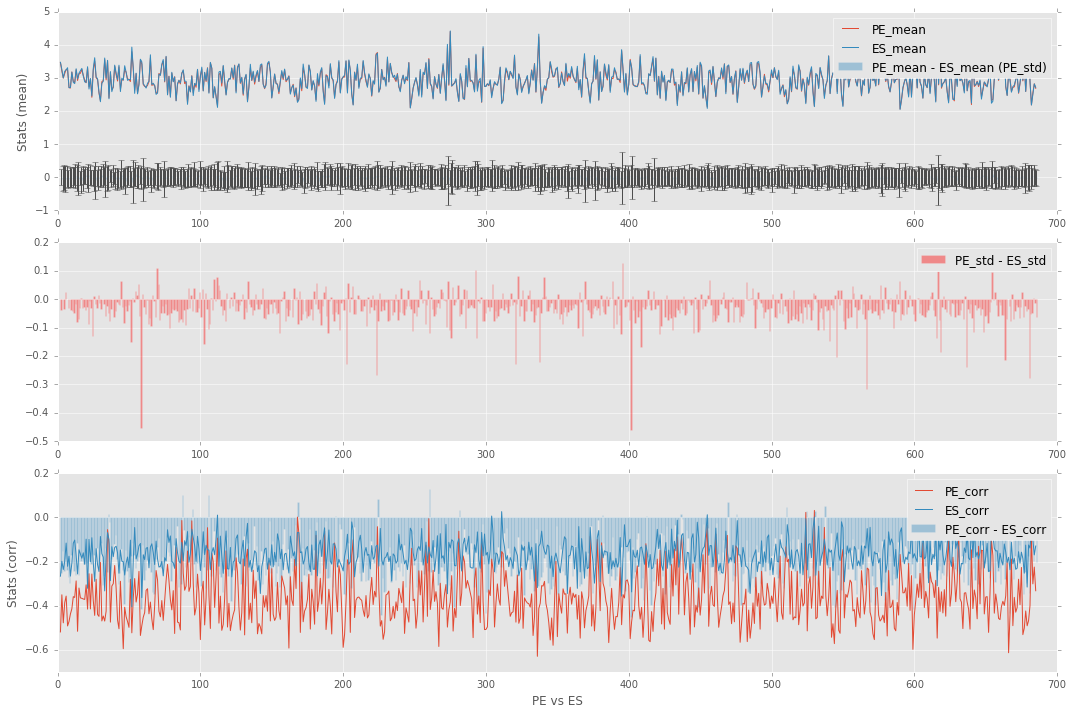

In [5]:
plt.rcParams['figure.figsize'] = (15, 10)
MC = 2
baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/NN_MC/'
#ES_file = baseline_dir + 'caffe_input/CV_Exp2_ADNI1_ADAS13_NN_OuterFold_{}_train_InnerFold_1.h5'.format(fid)
ES_file = baseline_dir + 'CV_Exp6_ADNI1_ADAS13_NN_train_MC_{}.h5'.format(MC)
PE_file = baseline_dir + 'CV_Exp6_ADNI1_ADAS13_NN_valid_MC_{}.h5'.format(MC)

show_plots = True
for fid in np.arange(1,2,1):
    print fid
    PE_data_X = load_data(PE_file,'Fold_{}_X_R_CT'.format(fid))
    PE_data_y = load_data(PE_file,'Fold_{}_valid_adas'.format(fid))
    #PE_data_y = load_data(PE_file,'Fold_{}_y3'.format(fid))

    #ES_data_X_L_HC = load_data(ES_file,'Fold_{}_X_L_HC'.format(fid))
    #ES_data_X_R_HC = load_data(ES_file,'Fold_{}_X_R_HC'.format(fid))
    #ES_data_X_CT = load_data(ES_file,'Fold_{}_X_R_CT'.format(fid))

    #ES_data_X = np.hstack((ES_data_X_L_HC,ES_data_X_R_HC,ES_data_X_CT))

    ES_data_X = load_data(ES_file,'Fold_{}_train_SpecCluster_dyn'.format(fid))
    ES_data_y = load_data(ES_file,'Fold_{}_train_adas'.format(fid))
    #ES_data_y = load_data(ES_file,'Fold_{}_train_y3'.format(fid))

    ES_QC(PE_data_X, PE_data_y, ES_data_X, ES_data_y,show_plots)


(19771, 686) (19771,)


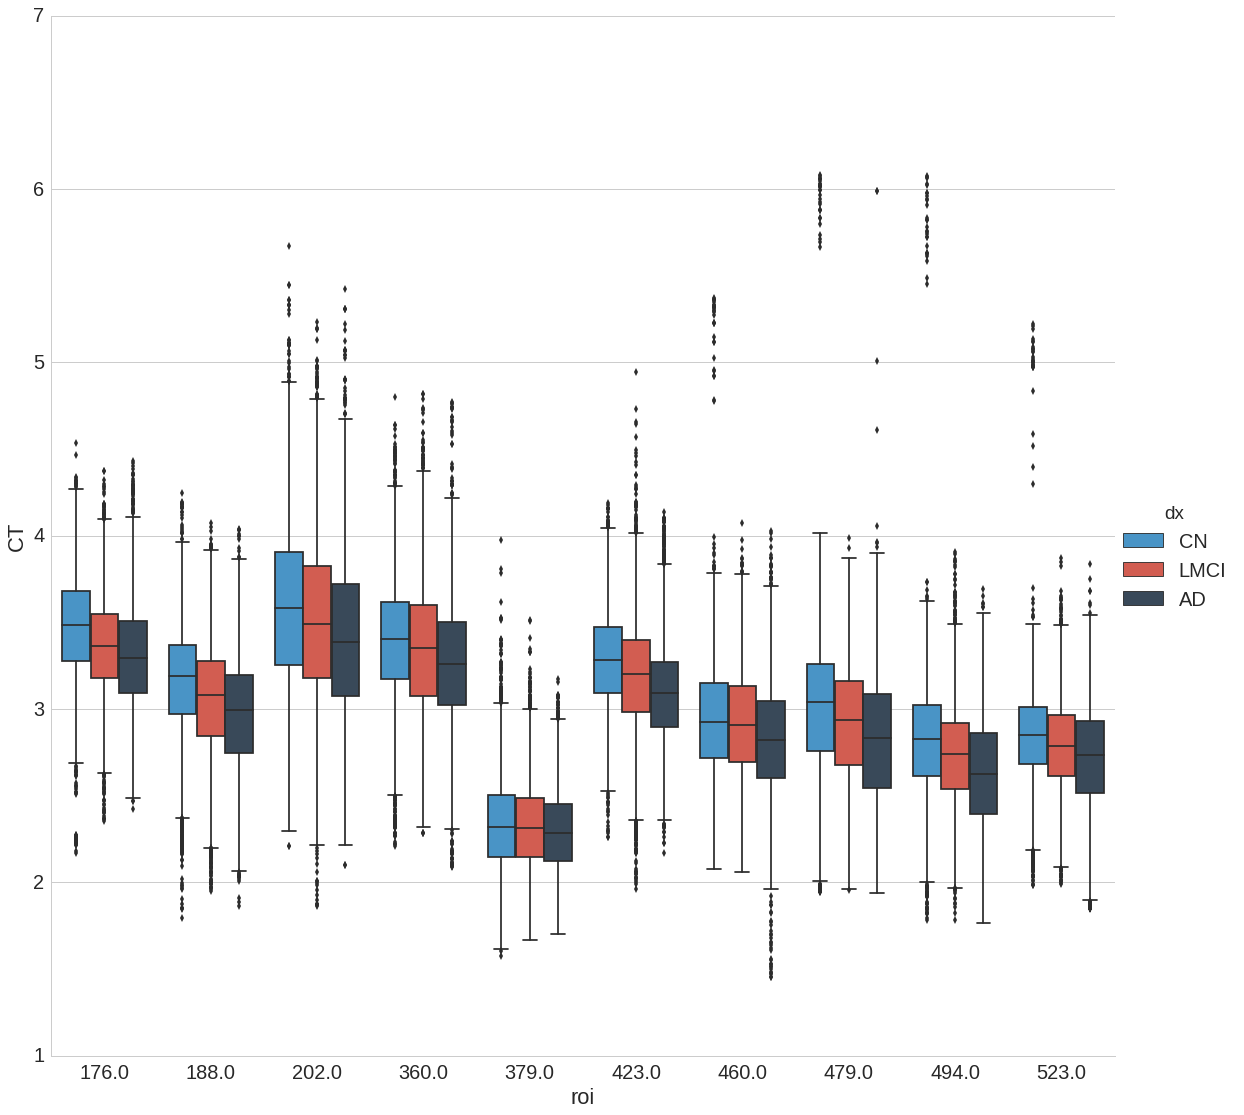

In [30]:
import seaborn as sns
# plt.figure()
# for r,roi in enumerate(ordered_roi_list):      
#     plt.subplot(8,10,r+1)
#     plt.hist(sub_roi_mat_sampx[:,r]-sub_roi_mat[:,r])


ES_data_X = load_data(ES_file,'Fold_{}_train_SpecCluster_dyn'.format(fid))
ES_data_y = load_data(ES_file,'Fold_{}_train_dx'.format(fid))

print ES_data_X.shape, ES_data_y.shape

df = pd.DataFrame(columns=['roi','dx','CT'])
df_concat = pd.DataFrame(columns=['roi','dx','CT'])

roi_list = np.random.choice(686, 10)

for roi in roi_list: #ES_data_X.shape[1]
    df['CT'] = ES_data_X[:,roi]
    df['roi'] = np.tile(roi,ES_data_X.shape[0])
    df['dx'] = ES_data_y
    
    df_concat = df_concat.append(df)

#plots


sns.set(font_scale=2)
flatui = [ "#3498db", "#e74c3c","#34495e", "#95a5a6", "#9b59b6","#2ecc71",]
palette = sns.color_palette(flatui)

with sns.axes_style("whitegrid"):
    g = sns.factorplot(x="roi", y='CT', hue='dx', sharey=True, data=df_concat, 
                       hue_order=['CN','LMCI','AD'], kind="box", palette=palette, size=16)

In [42]:
import scipy
for roi in roi_list:
    a = df_concat[(df_concat.roi==roi)&(df_concat.dx=='CN')]['CT']
    b = df_concat[(df_concat.roi==roi)&(df_concat.dx=='AD')]['CT']

    bartlett = scipy.stats.bartlett(a,b)
    levene = scipy.stats.levene(a,b)

    print bartlett
    print levene

BartlettResult(statistic=17.867151898921676, pvalue=2.3687460228680688e-05)
LeveneResult(statistic=16.783227007184994, pvalue=4.2221927962053337e-05)
BartlettResult(statistic=0.59622524432421553, pvalue=0.440021901569282)
LeveneResult(statistic=0.024553353686689539, pvalue=0.87548821290516421)
BartlettResult(statistic=75.255822330770243, pvalue=4.1350915044995709e-18)
LeveneResult(statistic=154.12481389217623, pvalue=3.8714508478049052e-35)
BartlettResult(statistic=8.0552264671368601, pvalue=0.0045372571089126621)
LeveneResult(statistic=29.793686590976389, pvalue=4.9166756187738534e-08)
BartlettResult(statistic=18.495934075297349, pvalue=1.7026714767782162e-05)
LeveneResult(statistic=3.4147068890844805, pvalue=0.064646455427979282)
BartlettResult(statistic=22.812601049118872, pvalue=1.7859090306476681e-06)
LeveneResult(statistic=14.641413657935479, pvalue=0.00013079191652482511)
BartlettResult(statistic=4.8941195552949477, pvalue=0.026948311175852724)
LeveneResult(statistic=0.545982466

In [ ]:
import h5py as h5
import tables as tb
import numpy as np

def create_dummy_vars(input_file, dataset, dummy_vars,save_to_file):        
    #takes a categorical output variable and changes to binary vectorized form
    #dummy_vars lists all the categories 
    dummy_var_match_list = []                    
    categorical_data = load_data(input_file, dataset, 'no_preproc')         
    for cat_data_item in categorical_data:        
        match_list = dummy_vars == cat_data_item                
        if np.sum(match_list) == 1:
            match_list = np.argmax(match_list)
            dummy_var_match_list.append(match_list)        
        else:
            print 'no match found for {}'.format(cat_data_item)
            
    
    output_vector = np.array(dummy_var_match_list)  
    #print output_vector
    #collapse LMCI-->EMCI and smcs-->CN
    output_vector[output_vector==2] = 1
    output_vector[output_vector==3] = 2
    output_vector[output_vector==4] = 2
    
    if save_to_file:
        print 'Adding vectorized dataset to: {}'.format(input_file)
        
#         hdf_data = h5.File(input_file, mode='a')            
#         hdf_data.create_dataset(dataset + '_vectorized', data=output_vector)            
#         hdf_data.close()   
        
        # use table to save data
        FILTERS = tb.Filters(complevel=5,complib='zlib')    
        fileh = tb.open_file(input_file, mode='a', filters=FILTERS)        
        data  = fileh.create_array(fileh.root, dataset + '_cat3', output_vector)
        fileh.close()
        
    else:
        print 'output_vector'
        print output_vector

In [ ]:
# create_dummy_vars for categorical Dx        
hdf_file = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/CV_Exp11_ADNI2_ADAS13_NN_valid.h5'
dataset = 'Fold_1_valid_dx'
save_to_file = False
dummy_vars = np.array(['AD', 'LMCI', 'EMCI', 'SMC', 'CN'])
dummy_var_array = create_dummy_vars(hdf_file, dataset, dummy_vars, save_to_file)

In [ ]:
def load_data(data_path, input_node):
    data = tb.open_file(data_path, 'r')
    X = data.get_node('/' + input_node)[:]
    data.close()
    return X

def generateInnerFold(OF_id, fold_name_prefix, out_file_prefix, in_file, n_innerFolds):
    import numpy as np
    import h5py as h5    
    import pandas as pd
    from scipy import stats
    from sklearn.cross_validation import KFold
    import pickle
    import re
    import random
    import collections
    from sklearn import preprocessing
    import tables as tb
    
    CT_SCALED = False #Scale CT modality to have values between [0,1] per dimension
    split_HC_CT = True #Split the HC and CT data layer to allow partitioned model
    
    # Load data
    data = tb.open_file(in_file, 'r')
   
    X_name = fold_name_prefix + '_X'    
    adas_name = fold_name_prefix + '_adas'
    mmse_name = fold_name_prefix + '_mmse'
    dx_name = fold_name_prefix + '_dx'
    
    #######################
    AAL_name = fold_name_prefix + '_SpecCluster_dyn'
    print in_file, AAL_name
    AAL = data.get_node('/' + AAL_name)[:]
    #######################
    
#     X_raw = data.get_node('/' + X_name)[:]
#     X = X_raw
#     print X.shape
   
#     adas_scores = data.get_node('/' + adas_name)[:]
#     mmse_scores = data.get_node('/' + mmse_name)[:]
#     dx_scores = data.get_node('/' + dx_name)[:]
    data.close()
        
    #Remove ROIs from ignore list       
    L_HC_offset = 16086 #12488 #9732 #11076 #11427
    R_HC_offset = 16471 #12263 #8953 #10161 #10519
    sampx = AAL.shape[0]
    #ignore_list_CT_idx = list(L_HC_offset + R_HC_offset + np.array([0,29,30,37,38]))
    #X = np.delete(X_raw, np.s_[ignore_list_CT_idx], 1)
    
    #Just create single fold (this avoids mixing of samples across the subjects)
    if n_innerFolds == 1:
        print "Creating single fold..."
        k=1
        train = np.arange(1,int(0.8*sampx),1)
        valid = np.arange(int(0.8*sampx),sampx,1)
        # Need to shuffle manually since no longer calling KFold
        #np.random.shuffle(train)
        #np.random.shuffle(valid)
        
        out_file_train = out_file_prefix + 'train_InnerFold_{}.h5'.format(k)
        out_file_valid = out_file_prefix + 'valid_InnerFold_{}.h5'.format(k)
        #Save Train
        output_data = h5.File(out_file_train, 'a')        
        print out_file_train        

#         X_all = X[train]
#         X_L_HC = X_all[:,:L_HC_offset]
#         X_R_HC = X_all[:,L_HC_offset:L_HC_offset+R_HC_offset]
#         X_CT = X_all[:,L_HC_offset+R_HC_offset:]
#         if CT_SCALED:
#             #scaler = preprocessing.MinMaxScaler()
#             print 'train'
#             print 'before scaling' + np.mean(X_CT, axis=1)
#             scaler = preprocessing.StandardScaler()
#             X_CT_scaler = scaler.fit_transform(X_CT) 
#             print 'after scaling' + np.mean(X_CT_scaler, axis=1)
#         else:
#             X_CT_scaler = X_CT

        if split_HC_CT:
####################            
#             output_data.create_dataset('Fold_{}_X_L_HC'.format(OF_id),data=X_L_HC)
#             output_data.create_dataset('Fold_{}_X_R_HC'.format(OF_id),data=X_R_HC)
#             output_data.create_dataset('Fold_{}_X_R_CT'.format(OF_id),data=X_CT_scaler)
####################
            CT_AAL = AAL[train,:]
            output_data.create_dataset('Fold_{}_CT_SpecCluster_dyn'.format(OF_id),data=CT_AAL)
        else:
            output_data.create_dataset('Fold_{}_X'.format(OF_id),data=X[train])
####################
#         output_data.create_dataset('Fold_{}_adas'.format(OF_id),data=adas_scores[train])
#         output_data.create_dataset('Fold_{}_mmse'.format(OF_id),data=mmse_scores[train])
#         output_data.create_dataset('Fold_{}_dx'.format(OF_id),data=dx_scores[train])
####################
        output_data.close()

        # Save valid
        output_data = h5.File(out_file_valid, 'a')

#         X_all = X[valid]
#         X_L_HC = X_all[:,:L_HC_offset]
#         X_R_HC = X_all[:,L_HC_offset:L_HC_offset+R_HC_offset]
#         X_CT = X_all[:,L_HC_offset+R_HC_offset:]
#         if CT_SCALED:
#             print 'valid'
#             print 'before scaling' + np.mean(X_CT, axis=1)
#             scaler = preprocessing.StandardScaler()
#             X_CT_scaler = scaler.fit_transform(X_CT) 
#             print 'after scaling' + np.mean(X_CT_scaler, axis=1) 
#         else:
#             X_CT_scaler = X_CT

        if split_HC_CT:
####################
#             output_data.create_dataset('Fold_{}_X_L_HC'.format(OF_id),data=X_L_HC)
#             output_data.create_dataset('Fold_{}_X_R_HC'.format(OF_id),data=X_R_HC)
#             output_data.create_dataset('Fold_{}_X_R_CT'.format(OF_id),data=X_CT_scaler)
####################
            CT_AAL = AAL[valid,:]
            output_data.create_dataset('Fold_{}_CT_SpecCluster_dyn'.format(OF_id),data=CT_AAL)
        else:
            output_data.create_dataset('Fold_{}_X'.format(OF_id),data=X[valid])
####################
#         output_data.create_dataset('Fold_{}_adas'.format(OF_id),data=adas_scores[valid])
#         output_data.create_dataset('Fold_{}_mmse'.format(OF_id),data=mmse_scores[valid])
#         output_data.create_dataset('Fold_{}_dx'.format(OF_id),data=dx_scores[valid])
####################

        output_data.close()
        
    else: #Sample / Shuffle Data (not a good idea)
        kf = KFold(sampx, n_folds=n_innerFolds,shuffle=True)
        k=0
        for train, valid in kf:
            k+=1
            out_file_train = out_file_prefix + 'train_InnerFold_{}.h5'.format(k)
            out_file_valid = out_file_prefix + 'valid_InnerFold_{}.h5'.format(k)
            #Save Train
            output_data = h5.File(out_file_train, 'a')
            X_all = X[train]
            if split_HC_CT:
                output_data.create_dataset('Fold_{}_X_L_HC'.format(OF_id),data=X_all[:,:L_HC_offset])
                output_data.create_dataset('Fold_{}_X_R_HC'.format(OF_id),data=X_all[:,L_HC_offset:L_HC_offset+R_HC_offset])
                output_data.create_dataset('Fold_{}_X_R_CT'.format(OF_id),data=X_all[:,L_HC_offset+R_HC_offset:])
            else:
                output_data.create_dataset('Fold_{}_X'.format(OF_id),data=X[train])

            output_data.create_dataset('Fold_{}_y'.format(OF_id),data=y[train])
            output_data.close()

            # Save valid
            output_data = h5.File(out_file_valid, 'a')
            X_all = X[valid]
            if split_HC_CT:
                output_data.create_dataset('Fold_{}_X_L_HC'.format(OF_id),data=X_all[:,:L_HC_offset])
                output_data.create_dataset('Fold_{}_X_R_HC'.format(OF_id),data=X_all[:,L_HC_offset:L_HC_offset+R_HC_offset])
                output_data.create_dataset('Fold_{}_X_R_CT'.format(OF_id),data=X_all[:,L_HC_offset+R_HC_offset:])
            else:
                output_data.create_dataset('Fold_{}_X'.format(OF_id),data=X[valid])

            output_data.create_dataset('Fold_{}_y'.format(OF_id),data=y[valid])
            output_data.close()


In [ ]:
#Create inner fold(s) for hyper-param tuning
exp_name = 'Exp6'
exp_name_out = 'Exp11'
cohort = 'ADNI2'
#outer_CV_fold_file = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/CV_Exp11_ADNI2_ADAS13_NN_train.h5'
#single_CV_fold_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/caffe_input/'
runParallel = True

single_CV_fold_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/NN_MC/'
n_innerFolds = 1
rc = ipp.Client()
#rc.block = False
dview = rc[:]
print dview
dview.push(dict(generateInnerFold = generateInnerFold))                   
outer_folds = np.arange(1,11,1)
mc_folds = np.arange(2,11,1)

for mc in mc_folds:
    outer_CV_fold_file = '{}CV_{}_{}_ADAS13_NN_train_MC_{}.h5'.format(single_CV_fold_dir,exp_name,cohort,mc)
    fold_name_prefix_list = []
    single_CV_fold_file_list = []
    for of in outer_folds:
        fold_name_prefix_list.append('Fold_{}_train'.format(of))
        single_CV_fold_file_list.append('{}caffe_input/CV_{}_{}_NN_OuterFold_MC_{}_fold{}_'.format(single_CV_fold_dir,
                                                                                               exp_name_out,cohort,mc,of)) 
        #generateInnerFold(outer_CV_fold_file, str(of), fold_name_prefix, n_innerFolds, single_CV_fold_file)

    
    if runParallel: #parallelized version:                
        mapfunc = partial(generateInnerFold, in_file=outer_CV_fold_file, n_innerFolds=n_innerFolds)
        parallel_result = dview.map_sync(mapfunc, outer_folds, fold_name_prefix_list, single_CV_fold_file_list)  


In [ ]:
p1=0.45
p2=0.6
p3=0.95

c1 = (1-p1)*(1-p2)
c2 = (1-p1)*(p2)
c3 = (p1)*(1-p3)
c4 = (p1)*(p3)

print c1,c2,c3,c4

In [ ]:
# Use this data for computing subject wise performance during outerloop cross-validation + held-out testset
# Partition the validation folds
from sklearn import preprocessing
CV = True
L_HC_offset = 16086 #12488 #9732 #11076 #11427
R_HC_offset = 16471 #12263 #8953 #10161 #10519

subset = 'valid'
CS_ONLY = False
CT_SCALED = False

#baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/'
baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/NN_MC/'
for mc in np.arange(1,11,1):
    in_file = 'CV_Exp6_ADNI2_NN_valid_MC_{}.h5'.format(mc)    

    if CV:
        CV_fused_data = h5.File(baseline_dir + in_file,'a')        
        for f in np.arange(10):
            X = CV_fused_data['Fold_{}_{}_X'.format(f+1,subset)][:]
            
            adas = CV_fused_data['Fold_{}_{}_adas'.format(f+1,subset)][:]
            mmse = CV_fused_data['Fold_{}_{}_mmse'.format(f+1,subset)][:]
            dx = CV_fused_data['Fold_{}_{}_dx'.format(f+1,subset)][:]

            CV_fused_data.create_dataset('Fold_{}_X_L_HC'.format(f+1),data=X[:,:L_HC_offset])
            CV_fused_data.create_dataset('Fold_{}_X_R_HC'.format(f+1),data=X[:,L_HC_offset:L_HC_offset+R_HC_offset])
            X_CT = X[:,L_HC_offset+R_HC_offset:]
            if CT_SCALED:
                #scaler = preprocessing.MinMaxScaler()
                scaler = preprocessing.StandardScaler()
                X_CT_scaled = scaler.fit_transform(X_CT)
                #X_CT_scaled = preprocessing.scale(X_CT)
            else:
                X_CT_scaled = X_CT
            #print np.mean(X_CT,axis=0)        
            #print np.mean(X_CT_scaled,axis=0)
            CV_fused_data.create_dataset('Fold_{}_X_R_CT'.format(f+1),data=X_CT_scaled)#Typo : R_CT        
            CV_fused_data.create_dataset('Fold_{}_adas'.format(f+1),data=adas) 
            CV_fused_data.create_dataset('Fold_{}_mmse'.format(f+1),data=mmse) 
            CV_fused_data.create_dataset('Fold_{}_dx'.format(f+1),data=dx) 

        #CV_valid_norm_data.close()
        CV_fused_data.close()

In [ ]:
single_CV_fold_file_list

In [ ]:
outer_CV_fold_file = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/CV_Exp2_ADNI1_ADAS13_NN_train.h5'


In [ ]:
#Generate map between AAL atlas ROI : index based on
AAL_roi_map_file = '/projects/nikhil/ADNI_prediction/input_datasets/CT/AAL_ROI_IDx'
AAL_roi_Name_featID_file = '/projects/nikhil/ADNI_prediction/input_datasets/CT/AAL_ROI_Name_featIDx.pkl'
ordered_roi_list = sub_CT_dict['40817'][0].keys()


ignore_roi_list = [0,29,30,39,40]
for roi in ignore_roi_list:
    ordered_roi_list.remove(roi)

ordered_roi_idx_dict = {}
for i,idx in enumerate(ordered_roi_list):
    ordered_roi_idx_dict[idx]=i

print ordered_roi_idx_dict
#data = pd.read_csv(AAL_roi_map_file,delim_whitespace=True)
print data.columns

data['feature_id'] = data['Ind'].map(ordered_roi_idx_dict) 
print data
#data = data[~np.isnan(data['feature_id'])]
#print data

roi_name_featIDx_Dict = data.set_index('feature_id')['Name'].to_dict()
od = collections.OrderedDict(sorted(roi_name_featIDx_Dict.items())) #order by feature colume index
print od

#f = open(AAL_roi_Name_featID_file, 'wb')
#pickle.dump(od, f)
#f.close()

#print 'total number of ROIs {}'.format(len(ordered_roi_list))
#ignore_roi_list = [0,29,30,39,40]

#for roi in ignore_roi_list:
#    print 'Ignore ROI index {}'.format(ordered_roi_list.index(roi))




In [ ]:
arr = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])
print arr.shape
l = [1,2]
arr_trunc = np.delete(arr, np.s_[l], 1)
print arr_trunc.shape

In [ ]:
#Create inflated HC total vol dataset (no voxel wise features)
def load_data(data_path, input_node):
    data = tb.open_file(data_path, 'r')
    X = data.get_node('/' + input_node)[:]
    data.close()
    return X


baseline_dir= '/projects/nikhil/ADNI_prediction/input_datasets/'
in_file = 'HC_CT_inflated_CV_subsets_MC5.h5'
out_file = 'total_HC_vol_CT_inflated_CV_subsets_MC5.h5'

L_HC_offset=11427
R_HC_offset=10519

ignore_cols = False
for lid in np.arange(6,11,1):
    print 'Starting Fold {}'.format(lid)
    out_train_X_raw = load_data(baseline_dir + in_file,'Fold_{}_train_X'.format(lid))
    out_train_y = load_data(baseline_dir + in_file,'Fold_{}_train_y'.format(lid))

    #out_valid_X_raw = load_data(baseline_dir + in_file,'Fold_{}_valid_X'.format(lid))
    #out_valid_y = load_data(baseline_dir + in_file,'Fold_{}_valid_y'.format(lid))

    #if you want to remove some CT columes (74 connundrum)
    if ignore_cols:
        ignore_list_CT_idx = list(L_HC_offset + R_HC_offset + np.array([0,29,30,37,38]))
        out_train_X = np.delete(out_train_X_raw, np.s_[ignore_list_CT_idx], 1)
        #out_valid_X = np.delete(out_valid_X_raw, np.s_[ignore_list_CT_idx], 1)
    else:
        out_train_X = out_train_X_raw
        #out_valid_X = out_valid_X_raw


    out_data = h5.File(baseline_dir + out_file,'a')
    #Train
    out_data.create_dataset('Fold_{}_train_X_L_HC'.format(lid),data=np.sum(out_train_X[:,:L_HC_offset],axis=1))
    out_data.create_dataset('Fold_{}_train_X_R_HC'.format(lid),data=np.sum(out_train_X[:,L_HC_offset:L_HC_offset+R_HC_offset],axis=1))
    out_data.create_dataset('Fold_{}_train_X_CT'.format(lid),data=out_train_X[:,L_HC_offset+R_HC_offset:])
    out_data.create_dataset('Fold_{}_train_y'.format(lid),data=out_train_y)
    #Valid
    #out_data.create_dataset('Fold_{}_valid_X_L_HC'.format(lid),data=np.sum(out_valid_X[:,:L_HC_offset],axis=1))
    #out_data.create_dataset('Fold_{}_valid_X_R_HC'.format(lid),data=np.sum(out_valid_X[:,L_HC_offset:L_HC_offset+R_HC_offset],axis=1))
    #out_data.create_dataset('Fold_{}_valid_X_CT'.format(lid),data=out_valid_X[:,L_HC_offset+R_HC_offset:])
    #out_data.create_dataset('Fold_{}_valid_y'.format(lid),data=out_valid_y)
    out_data.close()


In [ ]:
#Sanity checks 
def load_data(data_path, input_node):
    data = tb.open_file(data_path, 'r')
    X = data.get_node('/' + input_node)[:]
    data.close()
    return X

baseline_dir= '/projects/nikhil/ADNI_prediction/input_datasets/'
in_file1 = 'HC_CT_fused_CV_subsets_C688_valid_test.h5'
in_file2 = 'HC_CT_fused_CV_subsets_C688_valid.h5'

x1 = load_data(baseline_dir + in_file1,'Fold_1_valid_X')
y1 = load_data(baseline_dir + in_file1,'Fold_1_valid_y')

x2 = load_data(baseline_dir + in_file2,'Fold_1_valid_X')
y2 = load_data(baseline_dir + in_file2,'Fold_1_valid_y')

print zip(y1,y2)


In [ ]:
exp_setup_path = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/CV_Exp2_ADNI1_ADAS13.pkl'
exp_setup = pickle.load( open(exp_setup_path, "rb" ) )
kf = exp_setup['kf']
sub_list = exp_setup['common_subs']
train_fold_list=[]
val_fold_list=[]
for train, test in kf:
        tmp_train_list = []
        for t in train:
            tmp_train_list.append(sub_list[t])
        train_fold_list.append(tmp_train_list)
        
        tmp_val_list = []
        for t in test:
            tmp_val_list.append(sub_list[t])
        val_fold_list.append(tmp_val_list)

In [ ]:
#Delete hdf5 dataset! (works sometimes -- possibly with py tables datasets)
local_root = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/caffe_input/'

for fid in range(1,11,1):
    file_name = 'CV_Exp12_ADNI1and2_ADAS13_MMSE_NN_OuterFold_{}_valid_InnerFold_1.h5'.format(fid)
    dataset = 'Fold_{}_y3'.format(fid)
    print local_root + file_name, dataset
    with h5.File(local_root + file_name,  "a") as f:
        f.__delitem__(dataset)
        
    #f.close()